Testing to see if the membership function used in `Iron_Abell2151-Virgo_ITFR_MJ.ipynb` is causing a problem or not (it isn't).

# DESI Iron
Determine how many galaxies were observed in DESI Iron that are good TF targets by finding the number of unique galaxies observed with observations at the center and at .4R.

In [1]:
## Module imports and constant definitions 
from astropy.table import unique, Table
from astropy.coordinates import SkyCoord
from astropy.io import fits 

import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 

from tqdm.auto import tqdm

import os

import requests

from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

h = 1
H0 = 100*h
c = 3e5
q0 = 0.2
V0 = 2.5 # 0-point of TFR

### Iron Data
We read in the Iron data to use throughout the notebook. Commented out below is the Fuji data, to use to check against when necessary. 

In [2]:
tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_iron_healpix.fits')
#tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2852147603439621,198.369130660983,36.5372037049171,10475,main,0.815976335547845,7.38513168100107e-05,4,0.128754377365112,iron/healpix/main/dark/104/10475/redrock-main-dark-10475.fits,EXT,649377,198.36913066098333,36.537203704917076
2399148812795907,198.371733180003,36.4994335406917,10475,main,1.11088784970434,7.48767797671894e-05,4,7.9473560154438,iron/healpix/main/bright/104/10475/redrock-main-bright-10475.fits,EXT,649377,198.37173318000336,36.499433540691676
2399382443917318,184.845242475328,49.8157304793777,10995,main,1.14739342108157,0.000146302276719084,4,2.56771463155746,iron/healpix/main/bright/109/10995/redrock-main-bright-10995.fits,EXT,1008911,184.84524247532795,49.81573047937771
2399634072797192,184.341289722203,70.8283725474297,11965,main,1.51703376230705,6.28979649962091e-05,4,4.76254060305655,iron/healpix/main/bright/119/11965/redrock-main-bright-11965.fits,EXT,241234,184.34128972220284,70.82837254742968
2852141710442505,123.256011148025,36.2652948002806,6448,main,0.00787379494184006,3.4714052819995e-05,0,22.1719104201402,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061


### SGA
We read in the SGA to use throughout the notebook. 

In [3]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

## Create a dictionary of SGA IDs to find row indices 
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Separation between Galaxies and Observations
Find all targets on each galaxy, and then calculate distance between SGA center coordinates and observation coordinates. 

In [4]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.

## For each SGA galaxy that has 1+ observations, calculate distance for all of its targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    ## Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    ## Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    ## Calculate distance between each observation and the center of the galaxy
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)
    sep2d = target_coords.separation(SGA_coords)
    
    ## Add the distance to the tiron table
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    ## Add the distance in R26 to the tiron table 
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)

## Isolate the centers to be those measurements where the distance is <.1*R26
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

## Sort observations into center and axis observations 
iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

  0%|          | 0/75152 [00:00<?, ?it/s]

## Cleaning Iron Center Observations

Only keep those observations with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [5]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]

## Check for multiple good center observations 
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

If there's at least one good center observation, set the galaxy's redshift.

In [6]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    ## Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    ## Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be weighted average of all good center observation redshifts
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

Determine how many observations at $.4R$ we have. 

In [7]:
## Include all observations where .38R < distance < .42R in our .4R values
r0p4 = iron_axis[(iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)]

## Count how many of these are unique values
unique_centers = np.unique(good_centers['SGA_ID'])
unique_r0p4 = np.unique(r0p4['SGA_ID'])

centers_and_p4s = []
for i in unique_r0p4: 
    if i in unique_centers: 
        centers_and_p4s.append(i)

## Output the number of observations that are generally good for TF fitting
print(len(centers_and_p4s)," unique galaxies with center and .4R observations")

## Find the percentage of all Iron galaxies that are generally good for TF fitting
num_iron = len(np.unique(tiron['SGA_ID']))
percentage_TF = 100*((len(centers_and_p4s))/num_iron)
print(percentage_TF,"% of all Iron galaxies")

11819  unique galaxies with center and .4R observations
15.726793698105174 % of all Iron galaxies


## Cluster Membership
Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

### Tully et. al. (2015) Table 3

In [8]:
hdu = fits.open("../Tully15-Table3.fits")
table3 = Table(hdu[1].data)
table3.rename_column("<Vcmba>","VMod")
hdu.close()

table3_dict = {}
for i in range(len(table3)):
    table3_dict[table3['Nest'][i]] = i

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,VMod,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [9]:
## Check a suspicious value from later on in the notebook
table3[table3['Nest'] == 100526]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,VMod,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100526,4,42543,97.8357,1.6001,14.1,22525,36.76,1151,4.419,2170,1.53e+16,92.56


In [10]:
## Continue the suspicious value check 
cluster_coord = SkyCoord(table3['SGLON'][table3['Nest'] == 100526]*u.degree, 
                         table3['SGLAT'][table3['Nest'] == 100526]*u.degree, 
                         frame='supergalactic')
print(cluster_coord.transform_to('icrs'))

<SkyCoord (ICRS): (ra, dec) in deg
    [(190.1595305, 18.34388035)]>


### Tully et. al (2013) Table 2

In [11]:
hdu = fits.open("../Tully13-Table2.fit")
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


Loop through the SGA table to do just the rows that are for IDs we want from centers_and_p4s. Collect them into a smaller table. 

In [12]:
SGA.add_index("SGA_ID")
TF_SGA_cp4 = SGA.loc[centers_and_p4s]

TF_SGA_cp4[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06
55,SGA-2020 55,PGC1203947,1203947,199.73061299999998,1.7263548999999998,S?,159.49,0.35156044,0.510505,0.04396308,24.6

In [13]:
## Cluster Membership function. Takes argument of nest ID for the target cluster.

"""def cluster_membership(nest_id):
    c_4r_in_cluster = []
    
    ## Set active row for each nest number and base values 
    active_row = table3_dict[nest_id]
    R2t = table3["R2t"][active_row]
    sigma = table3["sigP"][active_row]
    
    ## Find the coordinates for each cluster
    cluster_coords = SkyCoord(table3["SGLON"][active_row]*u.degree, 
                       table3["SGLAT"][active_row]*u.degree, 
                       frame='supergalactic')
    
    group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')
    
    ## Match cluster to group coordinates 
    idx, d2d, d3d = cluster_coords.match_to_catalog_sky(group_coords)
    v = table2["__HV_"][idx]
    
    ## Match SGA coordinates from unique galaxies to nearest cluster
    SGA_coords = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')
    sep = cluster_coords.separation(SGA_coords)

    ## Convert R2t to an angle 
    R2t_angle = (R2t/(v/H0))*u.radian
    
    SGA_in_cluster1 = (sep < 1.5*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 3*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 3*sigma)
    SGA_in_cluster2 = (sep >= 1.5*R2t_angle) & (sep < 3*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 2*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 2*sigma)
    
    SGA_in_cluster = SGA_in_cluster1 | SGA_in_cluster2
    
    ## Keep observations that are within nest cluster 
    SGA_ID_in_cluster = TF_SGA_cp4["SGA_ID"][SGA_in_cluster]
    
    ## Gather centers and axes in the cluster
    centers_in_cluster = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_cluster)]
    axis_in_cluster = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_cluster)]
    
    c_4r_in_cluster.append(SGA_ID_in_cluster)
    return(c_4r_in_cluster, SGA_in_cluster, SGA_ID_in_cluster, centers_in_cluster, axis_in_cluster, cluster_coords, v, sep)"""

'def cluster_membership(nest_id):\n    c_4r_in_cluster = []\n    \n    ## Set active row for each nest number and base values \n    active_row = table3_dict[nest_id]\n    R2t = table3["R2t"][active_row]\n    sigma = table3["sigP"][active_row]\n    \n    ## Find the coordinates for each cluster\n    cluster_coords = SkyCoord(table3["SGLON"][active_row]*u.degree, \n                       table3["SGLAT"][active_row]*u.degree, \n                       frame=\'supergalactic\')\n    \n    group_coords = SkyCoord(table2[\'SGLON\']*u.degree, \n                        table2[\'SGLAT\']*u.degree, \n                        frame=\'supergalactic\')\n    \n    ## Match cluster to group coordinates \n    idx, d2d, d3d = cluster_coords.match_to_catalog_sky(group_coords)\n    v = table2["__HV_"][idx]\n    \n    ## Match SGA coordinates from unique galaxies to nearest cluster\n    SGA_coords = SkyCoord(TF_SGA_cp4[\'RA\'], TF_SGA_cp4[\'DEC\'], unit=\'deg\')\n    sep = cluster_coords.separation(SGA_coord

## Virgo Explicit Filtering
Testing just Virgo with the membership and cutting criteria.

In [14]:
c_4r_in_Virgo = []
    
## Set active row for Virgo nest and base values 
active_row_Virgo = table3_dict[100002]
R2t_Virgo = table3["R2t"][active_row_Virgo]
sigma_Virgo = table3["sigP"][active_row_Virgo]

## Find the coordinates for each cluster
Virgo_coords = SkyCoord(table3["SGLON"][active_row_Virgo]*u.degree, 
                   table3["SGLAT"][active_row_Virgo]*u.degree, 
                   frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                    table2['SGLAT']*u.degree, 
                    frame='supergalactic')

## Match cluster to group coordinates 
idx_Virgo, d2d_Virgo, d3d_Virgo = Virgo_coords.match_to_catalog_sky(group_coords)
v_Virgo = table2["__HV_"][idx_Virgo]

## Match SGA coordinates from unique galaxies to nearest cluster
SGA_coords_Virgo = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')
sep_Virgo = Virgo_coords.separation(SGA_coords_Virgo)

## Convert R2t to an angle 
R2t_Virgo_angle = (R2t_Virgo/(v_Virgo/H0))*u.radian

SGA_in_cluster1_Virgo = (sep_Virgo < 1.5*R2t_Virgo_angle) & (TF_SGA_cp4["Z_DESI"]*c > v_Virgo - 3*sigma_Virgo) & (TF_SGA_cp4["Z_DESI"]*c < v_Virgo + 3*sigma_Virgo)
SGA_in_cluster2_Virgo = (sep_Virgo >= 1.5*R2t_Virgo_angle) & (sep_Virgo < 3*R2t_Virgo_angle) & (TF_SGA_cp4["Z_DESI"]*c > v_Virgo - 2*sigma_Virgo) & (TF_SGA_cp4["Z_DESI"]*c < v_Virgo + 2*sigma_Virgo)

SGA_in_Virgo = SGA_in_cluster1_Virgo | SGA_in_cluster2_Virgo

## Keep observations that are within Virgo-2151
SGA_ID_in_Virgo = TF_SGA_cp4["SGA_ID"][SGA_in_Virgo]

## Gather centers and axes in the cluster
centers_in_Virgo = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Virgo)]
axis_in_Virgo = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_Virgo)]

c_4r_in_Virgo.append(SGA_ID_in_Virgo)

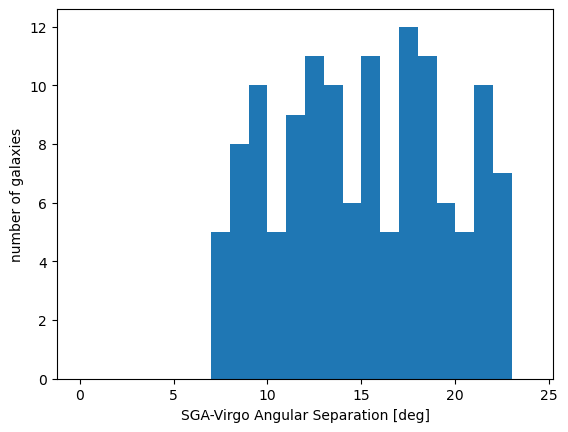

In [15]:
## make a bar graph of the angular separation 
plt.hist(sep_Virgo[SGA_in_Virgo].to_value('degree'), bins=np.arange(0,25, 1))
plt.xlabel('SGA-Virgo Angular Separation [deg]')
plt.ylabel('number of galaxies');

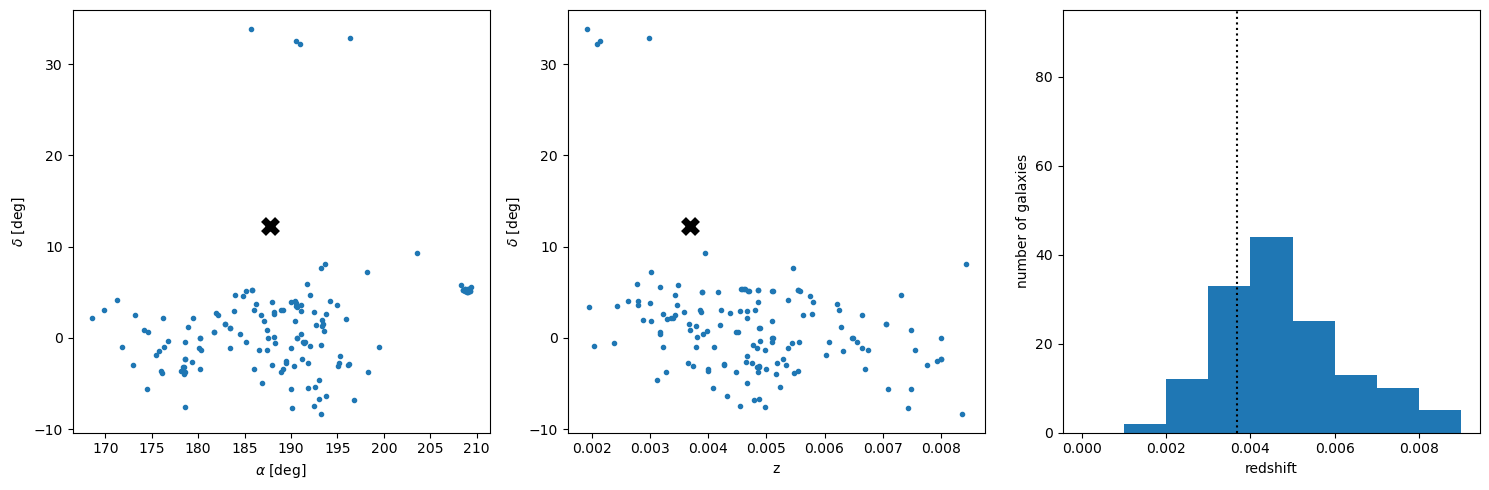

In [16]:
## plot the physical locations and the redshifts of the cluster

plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_in_Virgo['TARGET_RA'], centers_in_Virgo['TARGET_DEC'], '.')
plt.plot(Virgo_coords.transform_to('icrs').ra.deg, Virgo_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_in_Virgo['Z'], centers_in_Virgo['TARGET_DEC'], '.')
plt.plot(v_Virgo/c, Virgo_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_in_Virgo['Z'], bins=np.arange(0.0, .01, 0.001))
plt.vlines(v_Virgo/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

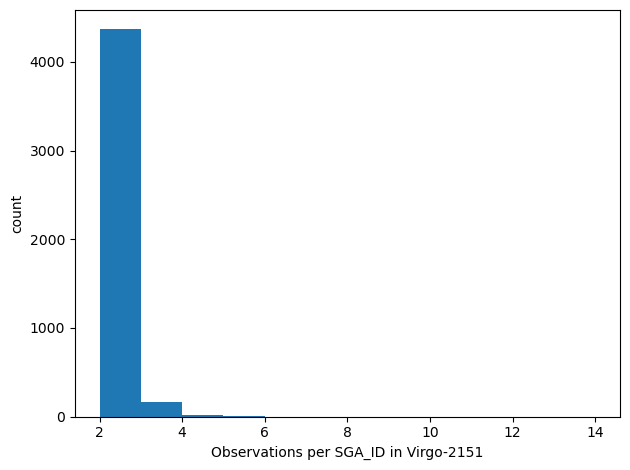

In [17]:
axis_SGAids_Virgo, axis_counts_Virgo = np.unique(axis_in_Virgo['SGA_ID'], return_counts=True)
center_SGAids_Virgo, center_counts_Virgo = np.unique(centers_in_Virgo['SGA_ID'], return_counts=True)

counts_Virgo = []

for sga_id in SGA_ID_in_Virgo:
    
    center_count_Virgo = 0
    axis_count_Virgo = 0
    
    if sga_id in center_SGAids_Virgo:
        
        center_count_Virgo = center_counts_Virgo[center_SGAids_Virgo == sga_id]
        
    if sga_id in axis_SGAids_Virgo:
        
        axis_count_Virgo = axis_counts_Virgo[axis_SGAids_Virgo == sga_id]
        
    count = center_count_Virgo + axis_count_Virgo
    
    if count > 1:
        
        counts_Virgo.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Virgo-2151')
plt.ylabel('count');

### Calculate the rotational velocity

In [18]:
axis_in_Virgo['SKY_FIBER_DIST'] = 0.
axis_in_Virgo['SKY_FIBER_DIST_R26'] = 0.
axis_in_Virgo['V_ROT'] = np.nan
axis_in_Virgo['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_in_Virgo['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_in_Virgo['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords_Virgo = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords_Virgo = SkyCoord(ra=axis_in_Virgo['RA'][obs_idx], 
                             dec=axis_in_Virgo['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d_Virgo = target_coords_Virgo.separation(center_coords_Virgo)
    
    axis_in_Virgo['SKY_FIBER_DIST'][obs_idx] = sep2d_Virgo
    axis_in_Virgo['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d_Virgo.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center_Virgo = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2_Virgo = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_in_Virgo['V_ROT'][obs_idx] = c*(axis_in_Virgo['Z'][obs_idx] - z_center_Virgo)
    axis_in_Virgo['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_in_Virgo['ZERR'][obs_idx]**2 + z_err_center2_Virgo)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_in_Virgo['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

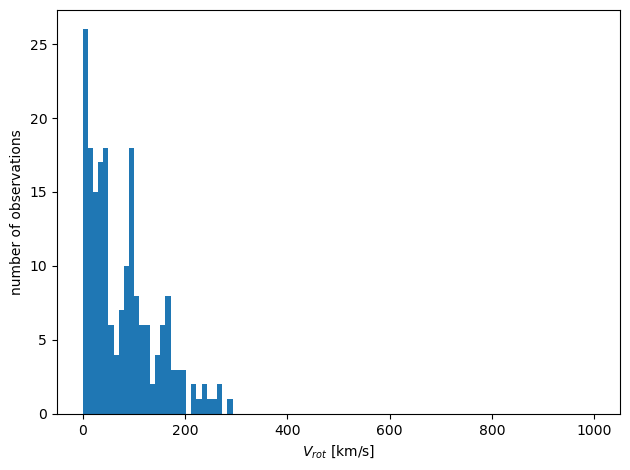

In [19]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_in_Virgo['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

### Cut for Virgo galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

#### Velocity Cut

In [20]:
r0p4_Virgo = (axis_in_Virgo['SKY_FIBER_DIST_R26'] > 0.38) & (axis_in_Virgo['SKY_FIBER_DIST_R26'] < 0.42)

Vgood_Virgo = (np.abs(axis_in_Virgo['V_ROT']) < 1000) & (np.abs(axis_in_Virgo['V_ROT']) > 10)

good_axis_in_Virgo = axis_in_Virgo[r0p4_Virgo & Vgood_Virgo]

print(len(good_axis_in_Virgo), len(np.unique(good_axis_in_Virgo['SGA_ID'])))

134 74


#### Relative Velocity Cut

In [21]:
good_deltaV_Virgo = np.ones(len(good_axis_in_Virgo), dtype=bool)

for sga_id in np.unique(good_axis_in_Virgo['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_in_Virgo['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin_Virgo = np.min(np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]))
        Vmax_Virgo = np.max(np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]))
        
        v_norm_min_Virgo = np.abs(good_axis_in_Virgo['V_ROT'][obs_idx])/Vmin_Virgo
        v_norm_max_Virgo = np.abs(good_axis_in_Virgo['V_ROT'][obs_idx])/Vmax_Virgo
        
        diff_matrix = np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin_Virgo
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_in_Virgo['DELTACHI2'] >= 25
            
            good_deltaV_Virgo[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin_Virgo = np.min(np.abs(good_axis_in_Virgo['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_in_Virgo['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_in_Virgo['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin_Virgo
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_Virgo[good_obs_idx] = False

In [22]:
good_deltaV_axis_in_Virgo = good_axis_in_Virgo[good_deltaV_Virgo]

print(len(good_deltaV_axis_in_Virgo), len(np.unique(good_deltaV_axis_in_Virgo['SGA_ID'])))

134 74


#### Inclination Angle Cut

In [23]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_in_Virgo['iSGA'] = -1

for i in range(len(good_deltaV_axis_in_Virgo)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_in_Virgo['SGA_ID'][i]]
    
    good_deltaV_axis_in_Virgo['iSGA'][i] = sga_idx
    
good_deltaV_axis_in_Virgo['cosi2'] = SGA['cosi2'][good_deltaV_axis_in_Virgo['iSGA']]

In [24]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_in_Virgo['cosi2'] <= cosi2_max

good_edge_axis_in_Virgo = good_deltaV_axis_in_Virgo[edge]

print(len(good_edge_axis_in_Virgo), len(np.unique(good_edge_axis_in_Virgo['SGA_ID'])))

113 62


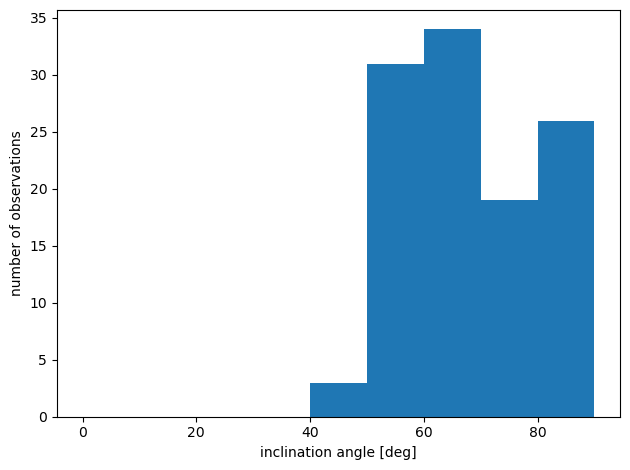

In [25]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_in_Virgo['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

#### Morphology Cut

In [26]:
good_edge_axis_in_Virgo['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_in_Virgo['iSGA']]

In [27]:
spirals_Virgo = np.zeros(len(good_edge_axis_in_Virgo), dtype=bool)

for i in range(len(good_edge_axis_in_Virgo)):
    
    try:    
        if (good_edge_axis_in_Virgo['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_in_Virgo['MORPHTYPE'][i][:2] != 'S0'):
            spirals_Virgo[i] = True
    except IndexError:
        print(good_edge_axis_in_Virgo['MORPHTYPE'][i])

good_edge_spirals_axis_in_Virgo = good_edge_axis_in_Virgo[spirals_Virgo]

print(len(good_edge_spirals_axis_in_Virgo), len(np.unique(good_edge_spirals_axis_in_Virgo['SGA_ID'])))

--
--
--
--
--
61 26


In [28]:
## This needs to be the variable-renamed version of the membership function

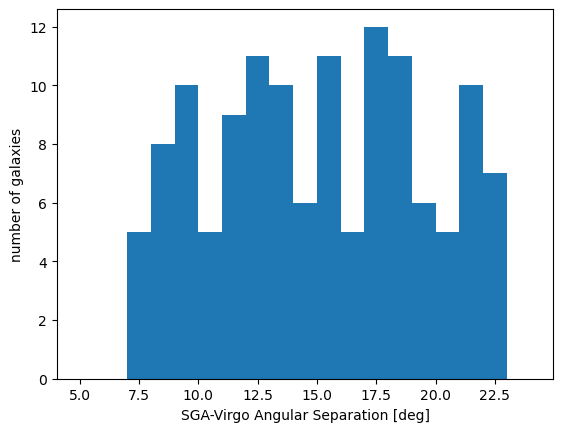

In [29]:
## make a bar graph of the angular separation 
plt.hist(sep_Virgo[SGA_in_Virgo].to_value('degree'), bins=np.arange(5,25, 1))
plt.xlabel('SGA-Virgo Angular Separation [deg]')
plt.ylabel('number of galaxies');

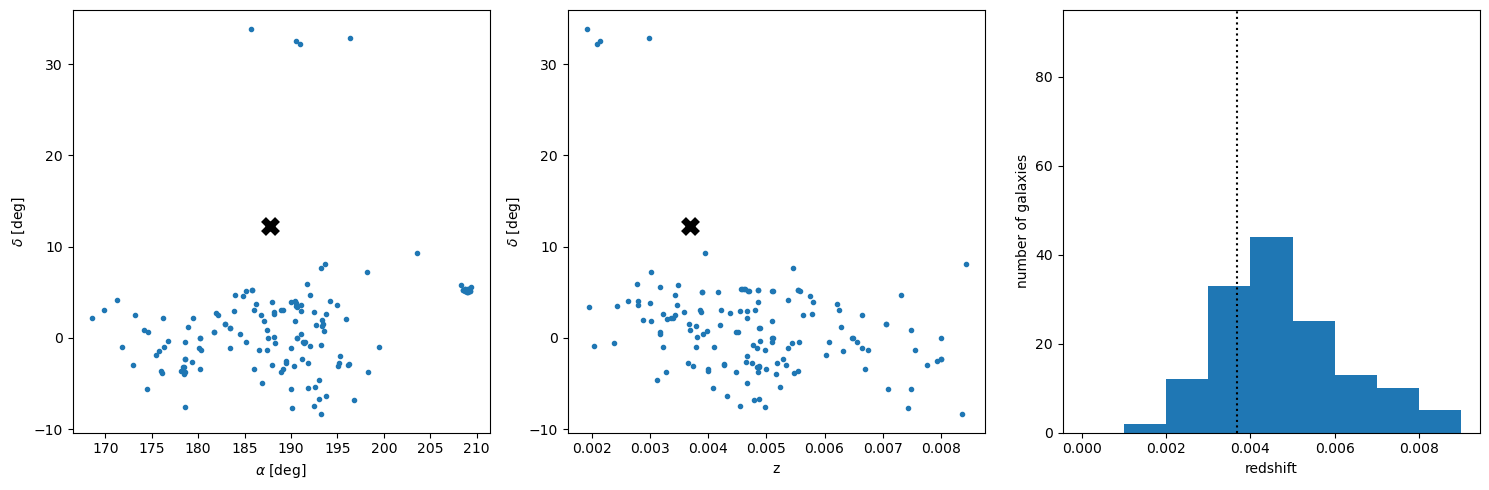

In [30]:
## plot the physical locations and the redshifts of the cluster

plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_in_Virgo['TARGET_RA'], centers_in_Virgo['TARGET_DEC'], '.')
plt.plot(Virgo_coords.transform_to('icrs').ra.deg, Virgo_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_in_Virgo['Z'], centers_in_Virgo['TARGET_DEC'], '.')
plt.plot(v_Virgo/c, Virgo_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_in_Virgo['Z'], bins=np.arange(0, .01, 0.001))
plt.vlines(v_Virgo/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

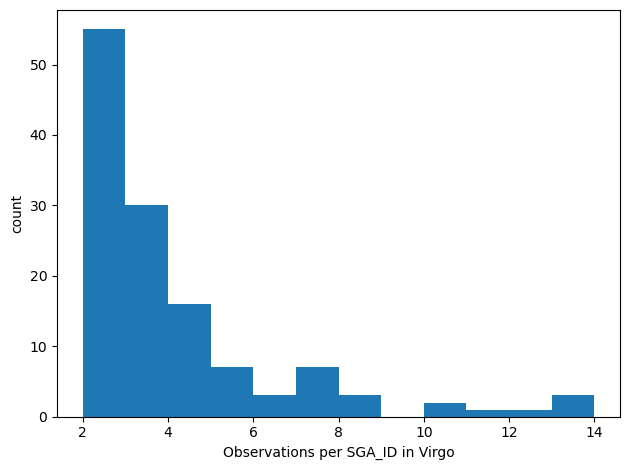

In [31]:
axis_SGAids, axis_counts = np.unique(axis_in_Virgo['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_in_Virgo['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Virgo:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Virgo')
plt.ylabel('count');